In [422]:
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from networkx.algorithms.community import greedy_modularity_communities
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


import dask.dataframe as dd
import html
import matplotlib.pyplot as plt
import networkx as nx
import psutil
import pandas as pd
import pickle as pkl
import re
import seaborn as sns
import time

### Network Generation [1:2]: The DataFrame

In [322]:
# Read the data
questions = pd.read_pickle('./pickle_dataframes/questions_with_sentiment.pkl')
answers = pd.concat([pd.read_pickle('./pickle_dataframes/answers_with_sentiment1.pkl'), 
                     pd.read_pickle('./pickle_dataframes/answers_with_sentiment2.pkl')]).reset_index(drop=True)
comments = pd.read_pickle('./pickle_dataframes/comments_with_sentiment.pkl')

users = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')

In [323]:
questions.OwnerUserId.unique().shape

(924,)

In [324]:
# Preparing a list of question IDs
parent_list = questions.Id.tolist()

# Identifying Comments Associated with Questions and Answers
comments_on_questions = comments[comments['PostId'].isin(questions['Id'])]
comments_on_answers = comments[comments['PostId'].isin(answers['Id'])]

In [325]:
# Aggregating commenters by the post they commented on
comments_on_questions_agg = comments_on_questions.groupby('PostId')['UserId'].apply(list).reset_index()
comments_on_answers_agg = comments_on_answers.groupby('PostId')['UserId'].apply(list).reset_index()
comments_on_questions_agg.head(1)

PostId          UserId
0       1  [28, 18, 8018]

In [326]:
# Mapping Answer IDs to their corresponding Question IDs
answer_to_question_map = answers.set_index('Id')['ParentId'].to_dict()
comments_on_answers_agg['MappedPostId'] = comments_on_answers_agg['PostId'].map(lambda x: answer_to_question_map.get(x, None))

# Filtering out None values which have no corresponding question
comments_on_answers_agg = comments_on_answers_agg[comments_on_answers_agg['MappedPostId'].notnull()]

comments_on_answers_agg.head(1)

PostId  UserId  MappedPostId
0       4  [7014]             1

In [327]:
# Creating a unified DataFrame for comment data
comments_combined = pd.concat([
    comments_on_questions_agg.rename(columns={'PostId': 'QuestionId', 'UserId': 'CommentOnQuestionUserId_list'}),
    comments_on_answers_agg.rename(columns={'MappedPostId': 'QuestionId', 'UserId': 'CommentOnAnswersUserId_list'})
], ignore_index=True)

# Replacing NaN values with empty lists
comments_combined['CommentOnQuestionUserId_list'] = comments_combined['CommentOnQuestionUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
comments_combined['CommentOnAnswersUserId_list'] = comments_combined['CommentOnAnswersUserId_list'].apply(lambda x: x if isinstance(x, list) else [])

# Grouping and combining lists
comments_combined = comments_combined.groupby('QuestionId').agg(
    CommentOnQuestionUserId_list=('CommentOnQuestionUserId_list', lambda x: sum(x, [])),
    CommentOnAnswersUserId_list=('CommentOnAnswersUserId_list', lambda x: sum(x, []))
).reset_index()
comments_combined.head(1)

QuestionId CommentOnQuestionUserId_list CommentOnAnswersUserId_list
0           1               [28, 18, 8018]                [7014, 9921]

In [328]:
# Filtering answers that are related to the collected questions
df_int = answers[answers.ParentId.isin(parent_list)]
df_int.head(1)

Id  PostTypeId  ParentId  AcceptedAnswerId            CreationDate  Score  \
0   4           2         1                -1 2012-12-04 21:58:11.187      7   

   ViewCount                                               Body  OwnerUserId  \
0         -1  <p>First-past-the-post voting tends to result ...           26   

         LastActivityDate         Title          Tags  AnswerCount  \
0 2012-12-04 21:58:11.187  Comment: N/A  Comment: N/A           -1   

   CommentCount  AnswerTopic  \
0             1            7   

                                      Body_Processed  BodySentiment  
0  first past post voting tends result smaller nu...         0.9788

In [329]:
# Grouping answers by their parent question and aggregating answerer user IDs
df_subpost = df_int.groupby('ParentId').agg(
    answers_UserId_list=('OwnerUserId', lambda x: list(x))
).reset_index(drop=False)
df_subpost.head(1)

ParentId answers_UserId_list
0         1       [26, 8, 4666]

In [330]:
# Identifying original posters for each question
df_original_poster = questions[questions.Id.isin(df_int.ParentId.tolist())].copy()
df_original_poster = df_original_poster.groupby('Id').agg(
    original_poster_UserId=('OwnerUserId', lambda x: list(x))
)
df_original_poster.head(1)

original_poster_UserId
Id                       
1                    [18]

In [331]:
# Merging to form a comprehensive DataFrame for graph construction
df_graph = pd.merge(
    left=df_original_poster,
    right=df_subpost,
    left_on='Id',
    right_on='ParentId'
)

# Cleaning up the 'original_poster' column
df_graph['original_poster_UserId'] = df_graph['original_poster_UserId'].apply(lambda x: x[0] if x else None)

# Integrating Comment Data with the Graph Data
df_graph = pd.merge(df_graph, comments_combined, left_on='ParentId', right_on='QuestionId', how='left')

In [332]:
df_graph['CommentOnQuestionUserId_list'] = df_graph['CommentOnQuestionUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
df_graph['CommentOnAnswersUserId_list'] = df_graph['CommentOnAnswersUserId_list'].apply(lambda x: x if isinstance(x, list) else [])

print(df_graph.shape)
df_graph = df_graph[df_graph['original_poster_UserId'] != -1]
print(df_graph.shape)

(10476, 6)
(9669, 6)


#### If you want to see how to get each of the values in df_graph's columns expand below rows: 

In [333]:
# displaying the different columns of row 1 manually
df_graph.head(1)

original_poster_UserId  ParentId answers_UserId_list  QuestionId  \
0                      18         1       [26, 8, 4666]         1.0   

  CommentOnQuestionUserId_list CommentOnAnswersUserId_list  
0               [28, 18, 8018]                [7014, 9921]

In [334]:
# We look at question 1
# We see that it belongs to questions['OwnerUserId']==18 (original_poster_UserId==18)
questions[questions['Id']==1]

Id  PostTypeId  ParentId  AcceptedAnswerId            CreationDate  Score  \
0   1           1        -1                 5 2012-12-04 21:40:29.743     42   

   ViewCount                                               Body  OwnerUserId  \
0       8309  know situation could arise u one candidate win...           18   

         LastActivityDate                                          Title Tags  \
0 2019-06-29 09:18:38.430  disadvantage first past post electoral system        

   AnswerCount  CommentCount  \
0            3             3   

                                        CombinedText  Topic  \
0  disadvantage first past post electoral system ...      7   

                                      Body_Processed  \
0  know situation could arise u one candidate win...   

                                 Title_Processed  BodySentiment  \
0  disadvantage first past post electoral system          0.886   

   TitleSentiment  
0         -0.4215

In [335]:
# We look at the answers to question 1
# We see that the answers['OwnerUserId'] corresponds to the users in df_graph['answers_UserId_list'] == [26, 8, 4666]	
answers[answers['ParentId']==1]

Id  PostTypeId  ParentId  AcceptedAnswerId            CreationDate  \
0         4           2         1                -1 2012-12-04 21:58:11.187   
1         5           2         1                -1 2012-12-04 21:58:39.037   
3077  10983           2         1                -1 2016-05-21 05:28:21.770   

      Score  ViewCount                                               Body  \
0         7         -1  <p>First-past-the-post voting tends to result ...   
1        47         -1  <p>Simple plurality voting has very little in ...   
3077      5         -1  <p>First-past-the-post systems are polarizing....   

      OwnerUserId        LastActivityDate         Title          Tags  \
0              26 2012-12-04 21:58:11.187  Comment: N/A  Comment: N/A   
1               8 2012-12-04 22:04:42.767  Comment: N/A  Comment: N/A   
3077         4666 2016-05-21 05:28:21.770  Comment: N/A  Comment: N/A   

      AnswerCount  CommentCount  AnswerTopic  \
0              -1             1            7   
1              -1             1            7   
3077           -1             0            7   

                                         Body_Processed  BodySentiment  
0     first past post voting tends result smaller nu...         0.9788  
1     simple plurality voting little favor election ...         0.9782  
3077  first past post system polarizing advantage ta...         0.9669

In [336]:
# We look at the comments on the questions (CommentersOnQuestion)
# We see that the comments['UserId'] corresponds to the users in df_graph['CommentersOnQuestion'] == [28, 18, 8018]	
comments[comments['PostId']==1]

Id  PostId  Score                                               Text  \
0         1       1      9  Is it fair to inquire about the disadvantages ...   
1         3       1      3  I could have reformulated the question, but at...   
7646  36295       1      0  You may find this cat's explanation interestin...   

                CreationDate  UserId  CommentTopic  \
0    2012-12-04 22:00:00.933      28             7   
1    2012-12-04 22:02:37.737      18             7   
7646 2016-05-19 12:09:10.397    8018             7   

                                         Text_Processed  TextSentiment  
0     fair inquire disadvantage without taking accou...         0.2732  
1     could reformulated question least disadvantage...         0.3269  
7646  may find cat explanation interesting http www ...         0.4019

In [337]:
# We look at the comments on the first/3 of the question answers
# We see that the comments['UserId'] corresponds to one of the user in df_graph['CommentersOnAnswers'] == [7014, 9921]	 
comments[comments['PostId']==4]

Id  PostId  Score  \
95611  97897       4      2   

                                                    Text  \
95611  The primary system used by America makes the p...   

                 CreationDate  UserId  CommentTopic  \
95611 2017-12-12 04:26:11.517    7014             7   

                                          Text_Processed  TextSentiment  
95611  primary system used america make polarization ...         0.7906

### Network Generation [2:2]: The graph

**We have to consider how we connect** 
- original_poster_UserId to CommentOnAnswersUserId_list
- answers_UserId_list to CommentOnAnswersUserId_list

Do we connect both or only one of them?
- In `G1` we connect original_poster_UserId to CommentOnAnswersUserId_list
- In `G2` we connect answers_UserId_list to CommentOnAnswersUserId_list
- In `G3` we connect both

In [338]:
G1 = nx.Graph()
# - original_poster_UserId to CommentOnAnswersUserId_list

# Adding nodes and edges for original posters, answerers, and commenters
for idx, row in df_graph.iterrows():
    original_poster_UserId = row['original_poster_UserId']
    G1.add_node(original_poster_UserId)

    # Add edges from original poster to answerers
    for user in row['answers_UserId_list']:
        G1.add_edge(original_poster_UserId, user)

    # Add edges from original poster to commenters on the question
    if isinstance(row['CommentOnQuestionUserId_list'], list):
        for commenter in row['CommentOnQuestionUserId_list']:
            G1.add_edge(original_poster_UserId, commenter)

    # Add edges from original poster to commenters on the answers
    if isinstance(row['CommentOnAnswersUserId_list'], list):
        for commenter in row['CommentOnAnswersUserId_list']:
            G1.add_edge(original_poster_UserId, commenter)

print(f'len(G1.nodes(): {len(G1.nodes(data=True))}', '\t', G1.nodes(data=True))
print(f'len(G1.edges()): {len(G1.edges())}', '\t', G1.edges())

len(G1.nodes(): 1463 	 [(18, {}), (26, {}), (8, {}), (4666, {}), (28, {}), (8018, {}), (7014, {}), (9921, {}), (52, {}), (14237, {}), (115, {}), (4800, {}), (69, {}), (174, {}), (175, {}), (232, {}), (300, {}), (4533, {}), (9418, {}), (29, {}), (1654, {}), (12464, {}), (21163, {}), (7303, {}), (78, {}), (22860, {}), (91, {}), (130, {}), (345, {}), (-1, {}), (11019, {}), (5534, {}), (1584, {}), (103, {}), (149, {}), (50, {}), (7434, {}), (2130, {}), (9801, {}), (342, {}), (22936, {}), (7460, {}), (16582, {}), (22982, {}), (6837, {}), (2571, {}), (5787, {}), (101, {}), (57, {}), (1471, {}), (2623, {}), (2833, {}), (5279, {}), (17279, {}), (16724, {}), (4789, {}), (4767, {}), (7265, {}), (23294, {}), (23, {}), (6738, {}), (2127, {}), (22137, {}), (6890, {}), (6927, {}), (15897, {}), (303, {}), (2951, {}), (1483, {}), (8260, {}), (5285, {}), (2721, {}), (5511, {}), (4482, {}), (1470, {}), (8784, {}), (14700, {}), (1370, {}), (12853, {}), (15531, {}), (8647, {}), (2747, {}), (14788, {}), (1

In [339]:
G2 = nx.Graph()

# - answers_UserId_list to CommentOnAnswersUserId_list
# - original_poster_UserId to CommentOnAnswersUserId_list

# Adding nodes and edges for original posters, answerers, and commenters
for idx, row in df_graph.iterrows():
    original_poster_UserId = row['original_poster_UserId']
    G2.add_node(original_poster_UserId)

    # Add edges from original poster to answerers
    for user in row['answers_UserId_list']:
        G2.add_edge(original_poster_UserId, user)

    # Add edges from original poster to commenters on the question
    if isinstance(row['CommentOnQuestionUserId_list'], list):
        for commenter in row['CommentOnQuestionUserId_list']:
            G2.add_edge(original_poster_UserId, commenter)

    # New Code: Add edges between answerers and users who commented on their answers
    if isinstance(row['answers_UserId_list'], list) and isinstance(row['CommentOnAnswersUserId_list'], list):
        for answerer in row['answers_UserId_list']:
            for commenter in row['CommentOnAnswersUserId_list']:
                G2.add_edge(answerer, commenter)

print(f'len(G2.nodes(): {len(G2.nodes(data=True))}', '\t', G2.nodes(data=True))
print(f'len(G2.edges()): {len(G2.edges())}', '\t', G2.edges())

len(G2.nodes(): 1463 	 [(18, {}), (26, {}), (8, {}), (4666, {}), (28, {}), (8018, {}), (7014, {}), (9921, {}), (52, {}), (14237, {}), (115, {}), (4800, {}), (69, {}), (174, {}), (175, {}), (232, {}), (300, {}), (4533, {}), (9418, {}), (29, {}), (1654, {}), (12464, {}), (21163, {}), (7303, {}), (78, {}), (22860, {}), (91, {}), (130, {}), (345, {}), (-1, {}), (11019, {}), (5534, {}), (1584, {}), (103, {}), (149, {}), (50, {}), (7434, {}), (2130, {}), (9801, {}), (342, {}), (22936, {}), (7460, {}), (16582, {}), (22982, {}), (6837, {}), (2571, {}), (5787, {}), (101, {}), (57, {}), (1471, {}), (2623, {}), (2833, {}), (5279, {}), (17279, {}), (16724, {}), (4789, {}), (4767, {}), (7265, {}), (23294, {}), (23, {}), (6738, {}), (2127, {}), (22137, {}), (6890, {}), (6927, {}), (15897, {}), (303, {}), (2951, {}), (1483, {}), (8260, {}), (5285, {}), (2721, {}), (5511, {}), (4482, {}), (1470, {}), (8784, {}), (14700, {}), (1370, {}), (12853, {}), (15531, {}), (8647, {}), (2747, {}), (14788, {}), (1

In [340]:
G3 = nx.Graph()

# - answers_UserId_list to CommentOnAnswersUserId_list
# - original_poster_UserId to CommentOnAnswersUserId_list

# Adding nodes and edges for original posters, answerers, and commenters
for idx, row in df_graph.iterrows():
    original_poster_UserId = row['original_poster_UserId']
    G3.add_node(original_poster_UserId)

    # Add edges from original poster to answerers
    for user in row['answers_UserId_list']:
        G3.add_edge(original_poster_UserId, user)

    # Add edges from original poster to commenters on the question
    if isinstance(row['CommentOnQuestionUserId_list'], list):
        for commenter in row['CommentOnQuestionUserId_list']:
            G3.add_edge(original_poster_UserId, commenter)

    # Add edges from original poster to commenters on the answers
    if isinstance(row['CommentOnAnswersUserId_list'], list):
        for commenter in row['CommentOnAnswersUserId_list']:
            G3.add_edge(original_poster_UserId, commenter)

    # New Code: Add edges between answerers and users who commented on their answers
    if isinstance(row['answers_UserId_list'], list) and isinstance(row['CommentOnAnswersUserId_list'], list):
        for answerer in row['answers_UserId_list']:
            for commenter in row['CommentOnAnswersUserId_list']:
                G3.add_edge(answerer, commenter)

print(f'len(G3.nodes(): {len(G3.nodes(data=True))}', '\t', G3.nodes(data=True))
print(f'len(G3.edges()): {len(G3.edges())}', '\t', G3.edges())

len(G3.nodes(): 1463 	 [(18, {}), (26, {}), (8, {}), (4666, {}), (28, {}), (8018, {}), (7014, {}), (9921, {}), (52, {}), (14237, {}), (115, {}), (4800, {}), (69, {}), (174, {}), (175, {}), (232, {}), (300, {}), (4533, {}), (9418, {}), (29, {}), (1654, {}), (12464, {}), (21163, {}), (7303, {}), (78, {}), (22860, {}), (91, {}), (130, {}), (345, {}), (-1, {}), (11019, {}), (5534, {}), (1584, {}), (103, {}), (149, {}), (50, {}), (7434, {}), (2130, {}), (9801, {}), (342, {}), (22936, {}), (7460, {}), (16582, {}), (22982, {}), (6837, {}), (2571, {}), (5787, {}), (101, {}), (57, {}), (1471, {}), (2623, {}), (2833, {}), (5279, {}), (17279, {}), (16724, {}), (4789, {}), (4767, {}), (7265, {}), (23294, {}), (23, {}), (6738, {}), (2127, {}), (22137, {}), (6890, {}), (6927, {}), (15897, {}), (303, {}), (2951, {}), (1483, {}), (8260, {}), (5285, {}), (2721, {}), (5511, {}), (4482, {}), (1470, {}), (8784, {}), (14700, {}), (1370, {}), (12853, {}), (15531, {}), (8647, {}), (2747, {}), (14788, {}), (1

### Network Analysis


In [348]:
# Calculate different network statistics
avg_degree_centrality = sum(nx.degree_centrality(G1).values()) / len(G1)
avg_clustering_coefficient = nx.average_clustering(G1)
connected_components = list(nx.connected_components(G1))
avg_betweenness_centrality = sum(nx.betweenness_centrality(G1).values()) / len(G1)
communities = greedy_modularity_communities(G1)

# Analysis - You might print these or plot them using matplotlib or similar
print("Average Degree Centrality:", avg_degree_centrality)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Number of Connected Components:", len(connected_components))
print("Average Betweenness Centrality:", avg_betweenness_centrality)
print("Number of Communities detected:", len(communities))

Average Degree Centrality: 0.03243994827262136
Average Clustering Coefficient: 0.3731202489653536
Number of Connected Components: 1
Average Betweenness Centrality: 0.0007910656467275
Number of Communities detected: 12


In [349]:
# Calculate different network statistics
avg_degree_centrality = sum(nx.degree_centrality(G2).values()) / len(G2)
avg_clustering_coefficient = nx.average_clustering(G2)
connected_components = list(nx.connected_components(G2))
avg_betweenness_centrality = sum(nx.betweenness_centrality(G2).values()) / len(G2)
communities = greedy_modularity_communities(G2)

# Analysis - You might print these or plot them using matplotlib or similar
print("Average Degree Centrality:", avg_degree_centrality)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Number of Connected Components:", len(connected_components))
print("Average Betweenness Centrality:", avg_betweenness_centrality)
print("Number of Communities detected:", len(communities))

Average Degree Centrality: 0.06903061658623631
Average Clustering Coefficient: 0.5390484157854091
Number of Connected Components: 1
Average Betweenness Centrality: 0.0006547757426202162
Number of Communities detected: 12


In [350]:
# Calculate different network statistics
avg_degree_centrality = sum(nx.degree_centrality(G3).values()) / len(G3)
avg_clustering_coefficient = nx.average_clustering(G3)
connected_components = list(nx.connected_components(G3))
avg_betweenness_centrality = sum(nx.betweenness_centrality(G3).values()) / len(G3)
communities = greedy_modularity_communities(G3)

# Analysis - You might print these or plot them using matplotlib or similar
print("Average Degree Centrality:", avg_degree_centrality)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Number of Connected Components:", len(connected_components))
print("Average Betweenness Centrality:", avg_betweenness_centrality)
print("Number of Communities detected:", len(communities))

Average Degree Centrality: 0.07672239920781958
Average Clustering Coefficient: 0.5374046079320877
Number of Connected Components: 1
Average Betweenness Centrality: 0.0006442757066173029
Number of Communities detected: 16


In [351]:
users_with_all_attributes = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')
users_with_all_attributes.head(2)

Id  Reputation            CreationDate          LastAccessDate  Views  \
1   5         315 2012-12-04 20:36:06.517 2021-07-05 18:03:41.037     49   
2   8        2777 2012-12-04 20:52:37.450 2022-07-31 22:39:03.850    832   

   UpVotes  DownVotes  QuestionCount  AnswerCount  CommentCount  ...   16  \
1       14         58            0.0          3.0          31.0  ...  0.0   
2       37          5            0.0         13.0          10.0  ...  0.0   

         17        18   19   20        21   22   23        24  \
1  0.029412  0.029412  0.0  0.0  0.058824  0.0  0.0  0.176471   
2  0.000000  0.000000  0.0  0.0  0.391304  0.0  0.0  0.086957   

   MostEngagedTopic  
1               3.0  
2              21.0  

[2 rows x 46 columns]

### K-Means Clustrering

In [385]:
# Note: Set 'verbose' to True to display the Elbow Method and Silhouette Analysis plots to base clustering adjustments on
def custom_cluster(target_dataframe, clustering_features, n_clusters, cluster_label, verbose=False, random_state=42):
    # Impute NaN values with 0
    clustering_features_imputed = target_dataframe[clustering_features].fillna(0)

    # Scale features
    scaler = StandardScaler()
    scaled_clustering_features = scaler.fit_transform(clustering_features_imputed)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
    kmeans.fit(scaled_clustering_features)

    # Add cluster labels to dataframe
    target_dataframe[cluster_label] = kmeans.labels_

    if verbose == True:
        # Elbow method
        wcss = []
        
        for i in range(1, 21):
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
            kmeans.fit(scaled_clustering_features)
            wcss.append(kmeans.inertia_)
            
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        
        axs[0].plot(range(1, 21), wcss)
        axs[0].set_xlabel('Number of Clusters')
        axs[0].set_ylabel('Within-Cluster Sum of Squares')
        axs[0].grid(True)
        axs[0].set_title('Elbow Method')

        # Silhouette analysis
        silhouette_scores = []
        
        for i in range(2, 21):
            kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
            kmeans.fit(scaled_clustering_features)
            silhouette_avg = silhouette_score(scaled_clustering_features, kmeans.labels_)
            silhouette_scores.append(silhouette_avg)

        axs[1].plot(range(2, 21), silhouette_scores)
        axs[1].set_xlabel('Number of Clusters')
        axs[1].set_ylabel('Silhouette Score')
        axs[1].grid(True)
        axs[1].set_title('Silhouette Analysis')

        plt.tight_layout()
        plt.show()

        # Display feature distributions between clusters
        num_features = len(clustering_features)
        num_rows = num_features // 5 + (1 if num_features % 5 > 0 else 0)
        num_cols = 5 if num_features >= 5 else num_features
        subplot_width = 4
        subplot_height = 4
        fig_width = subplot_width * num_cols
        fig_height = subplot_height * num_rows
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), constrained_layout=True)
        
        axs = axs.ravel()
        for i in range(len(axs)):
            if i < num_features:
                sns.boxplot(x=cluster_label, y=clustering_features[i], data=target_dataframe, ax=axs[i])
                axs[i].set_title(f'Distribution of {clustering_features[i]}')
                axs[i].set_xlabel('Cluster')
                axs[i].set_ylabel('Count')
            else:
                axs[i].set_visible(False)

        plt.show()

        # Display cluster information
        cluster_counts = target_dataframe[cluster_label].value_counts().sort_index()
        cluster_stats = pd.DataFrame(target_dataframe.groupby(cluster_label)[clustering_features].mean().add_suffix('Mean')).reset_index(drop=True)
        
        cluster_info = pd.concat([cluster_counts, cluster_stats], axis=1)
        cluster_info.rename(columns={cluster_label: 'Count', 'count': 'Count'}, inplace=True)
        cluster_info.index.name = 'Cluster'
        
        print(cluster_info)

### 1. Clustering by Activity Metrics

#### 1.1 Clustering by question count, answer count, and comment count

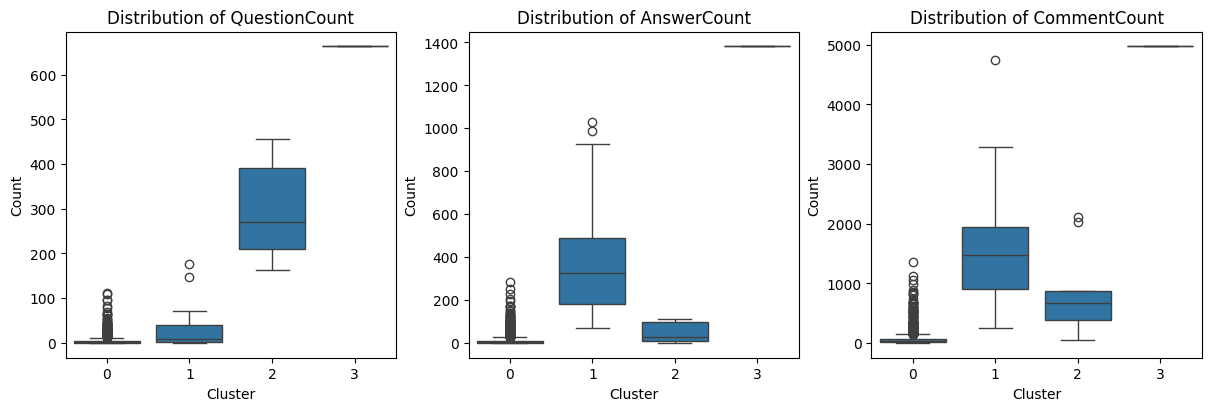

         Count  QuestionCountMean  AnswerCountMean  CommentCountMean
Cluster                                                             
0         1424           4.517556        12.245787         70.413624
1           29          27.827586       381.344828       1565.896552
2            9         294.555556        52.666667        845.555556
3            1         663.000000      1381.000000       4972.000000


In [369]:
clustering_features = ['QuestionCount', 'AnswerCount', 'CommentCount']

custom_cluster(users_with_all_attributes, clustering_features, 4, 'ActivityCluster', verbose=True)

### 2. Clustering by Quality Metrics

#### 2.1 Clustering by reputation, average question score, average answer score, and average comment score

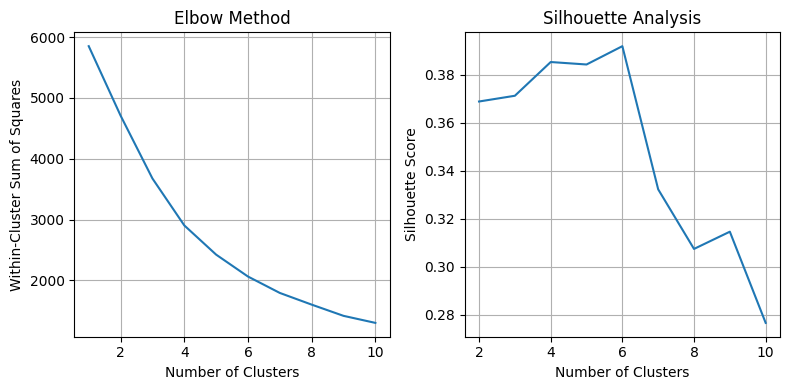

         Count  ReputationMean  AvgQuestionScoreMean  AvgAnswerScoreMean  \
Cluster                                                                    
0          933     1711.833869              6.682733            4.977559   
1          409     2223.853301              7.573918           15.665143   
2           16    74118.812500             10.385368           11.852085   
3          105     2632.095238             29.546801            9.559383   

         AvgCommentScoreMean  
Cluster                       
0                   1.042431  
1                   3.436663  
2                   1.729446  
3                   2.368631  


In [370]:
clustering_features = ['Reputation', 'AvgQuestionScore', 'AvgAnswerScore', 'AvgCommentScore']

custom_cluster(users_with_all_attributes, clustering_features, 4, 'Quality1Cluster', verbose=True)

#### 2.2 Clustering by accepted answer count and accepted answer fraction

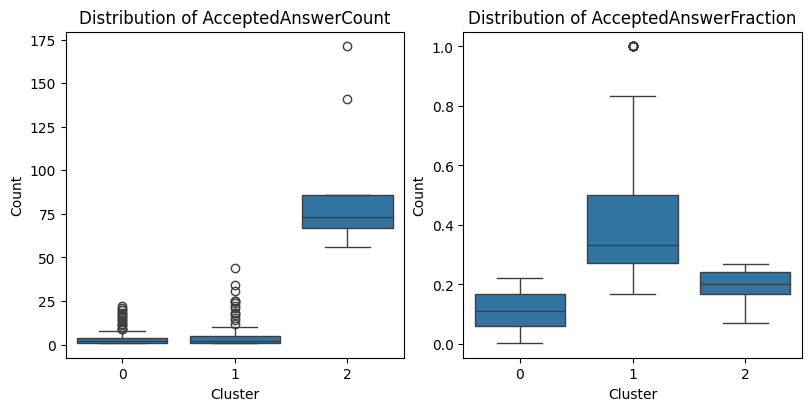

         Count  AcceptedAnswerCountMean  AcceptedAnswerFractionMean
Cluster                                                            
0         1334                 3.505102                    0.112406
1          120                 5.166667                    0.440166
2            9                88.888889                    0.187083


In [371]:
clustering_features = ['AcceptedAnswerCount', 'AcceptedAnswerFraction']

custom_cluster(users_with_all_attributes, clustering_features, 3, 'Quality2Cluster', verbose=True)

### 3. Clustering by Sentiment Metrics

#### 3.1 Clustering by average question body sentiment, average question title sentiment, average answer sentiment, average comment sentiment

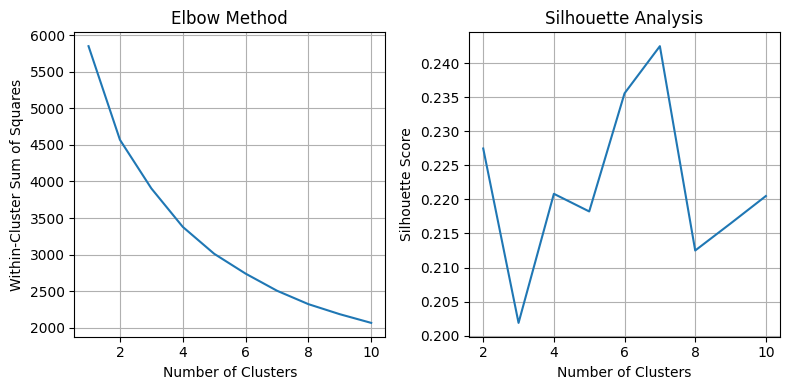

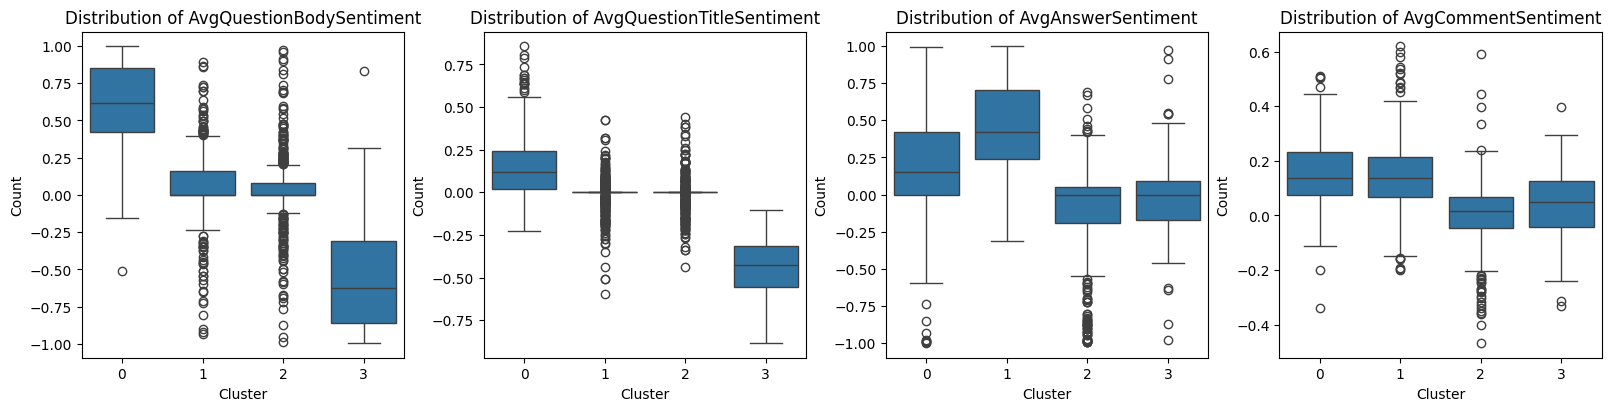

         Count  AvgQuestionBodySentimentMean  AvgQuestionTitleSentimentMean  \
Cluster                                                                       
0          320                      0.627018                       0.163162   
1          519                      0.055159                      -0.008394   
2          554                      0.030685                      -0.004889   
3           70                     -0.546127                      -0.444112   

         AvgAnswerSentimentMean  AvgCommentSentimentMean  
Cluster                                                   
0                      0.191663                 0.152359  
1                      0.454793                 0.144190  
2                     -0.091066                 0.005242  
3                      0.005493                 0.037914  


In [372]:
clustering_features = ['AvgQuestionBodySentiment', 'AvgQuestionTitleSentiment', 'AvgAnswerSentiment', 'AvgCommentSentiment']

custom_cluster(users_with_all_attributes, clustering_features, 4, 'SentimentCluster', verbose=True)

### 4. Clustering by Engagement Metrics

#### 4.1 Clustering by views, upvotes, and downvotes

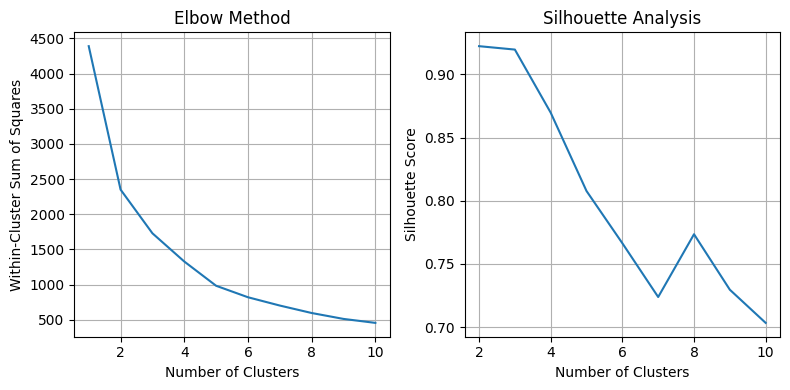

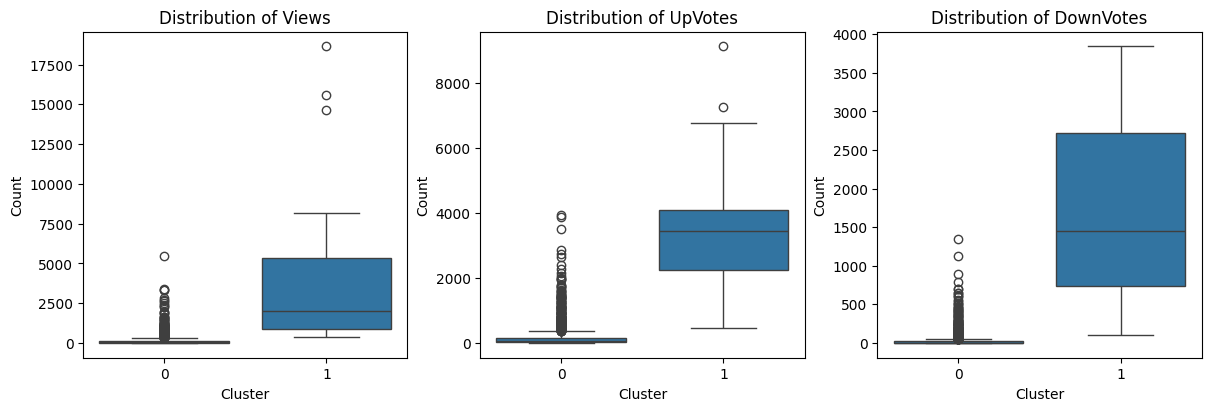

         Count    ViewsMean  UpVotesMean  DownVotesMean
Cluster                                                
0         1438   166.638387   176.061892      33.684284
1           25  4179.080000  3463.360000    1688.800000


In [373]:
clustering_features = ['Views', 'UpVotes', 'DownVotes']

custom_cluster(users_with_all_attributes, clustering_features, 2, 'EngagementCluster', verbose=True)

### 5. Clustering by Topic Engagement Metrics

#### 5.1 Clustering by topic engagement columns

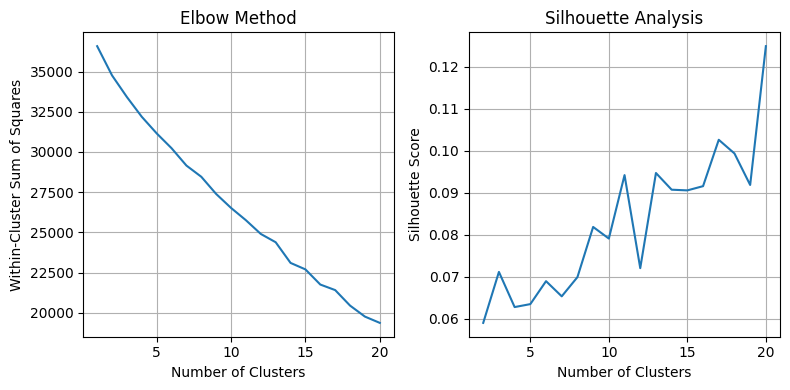

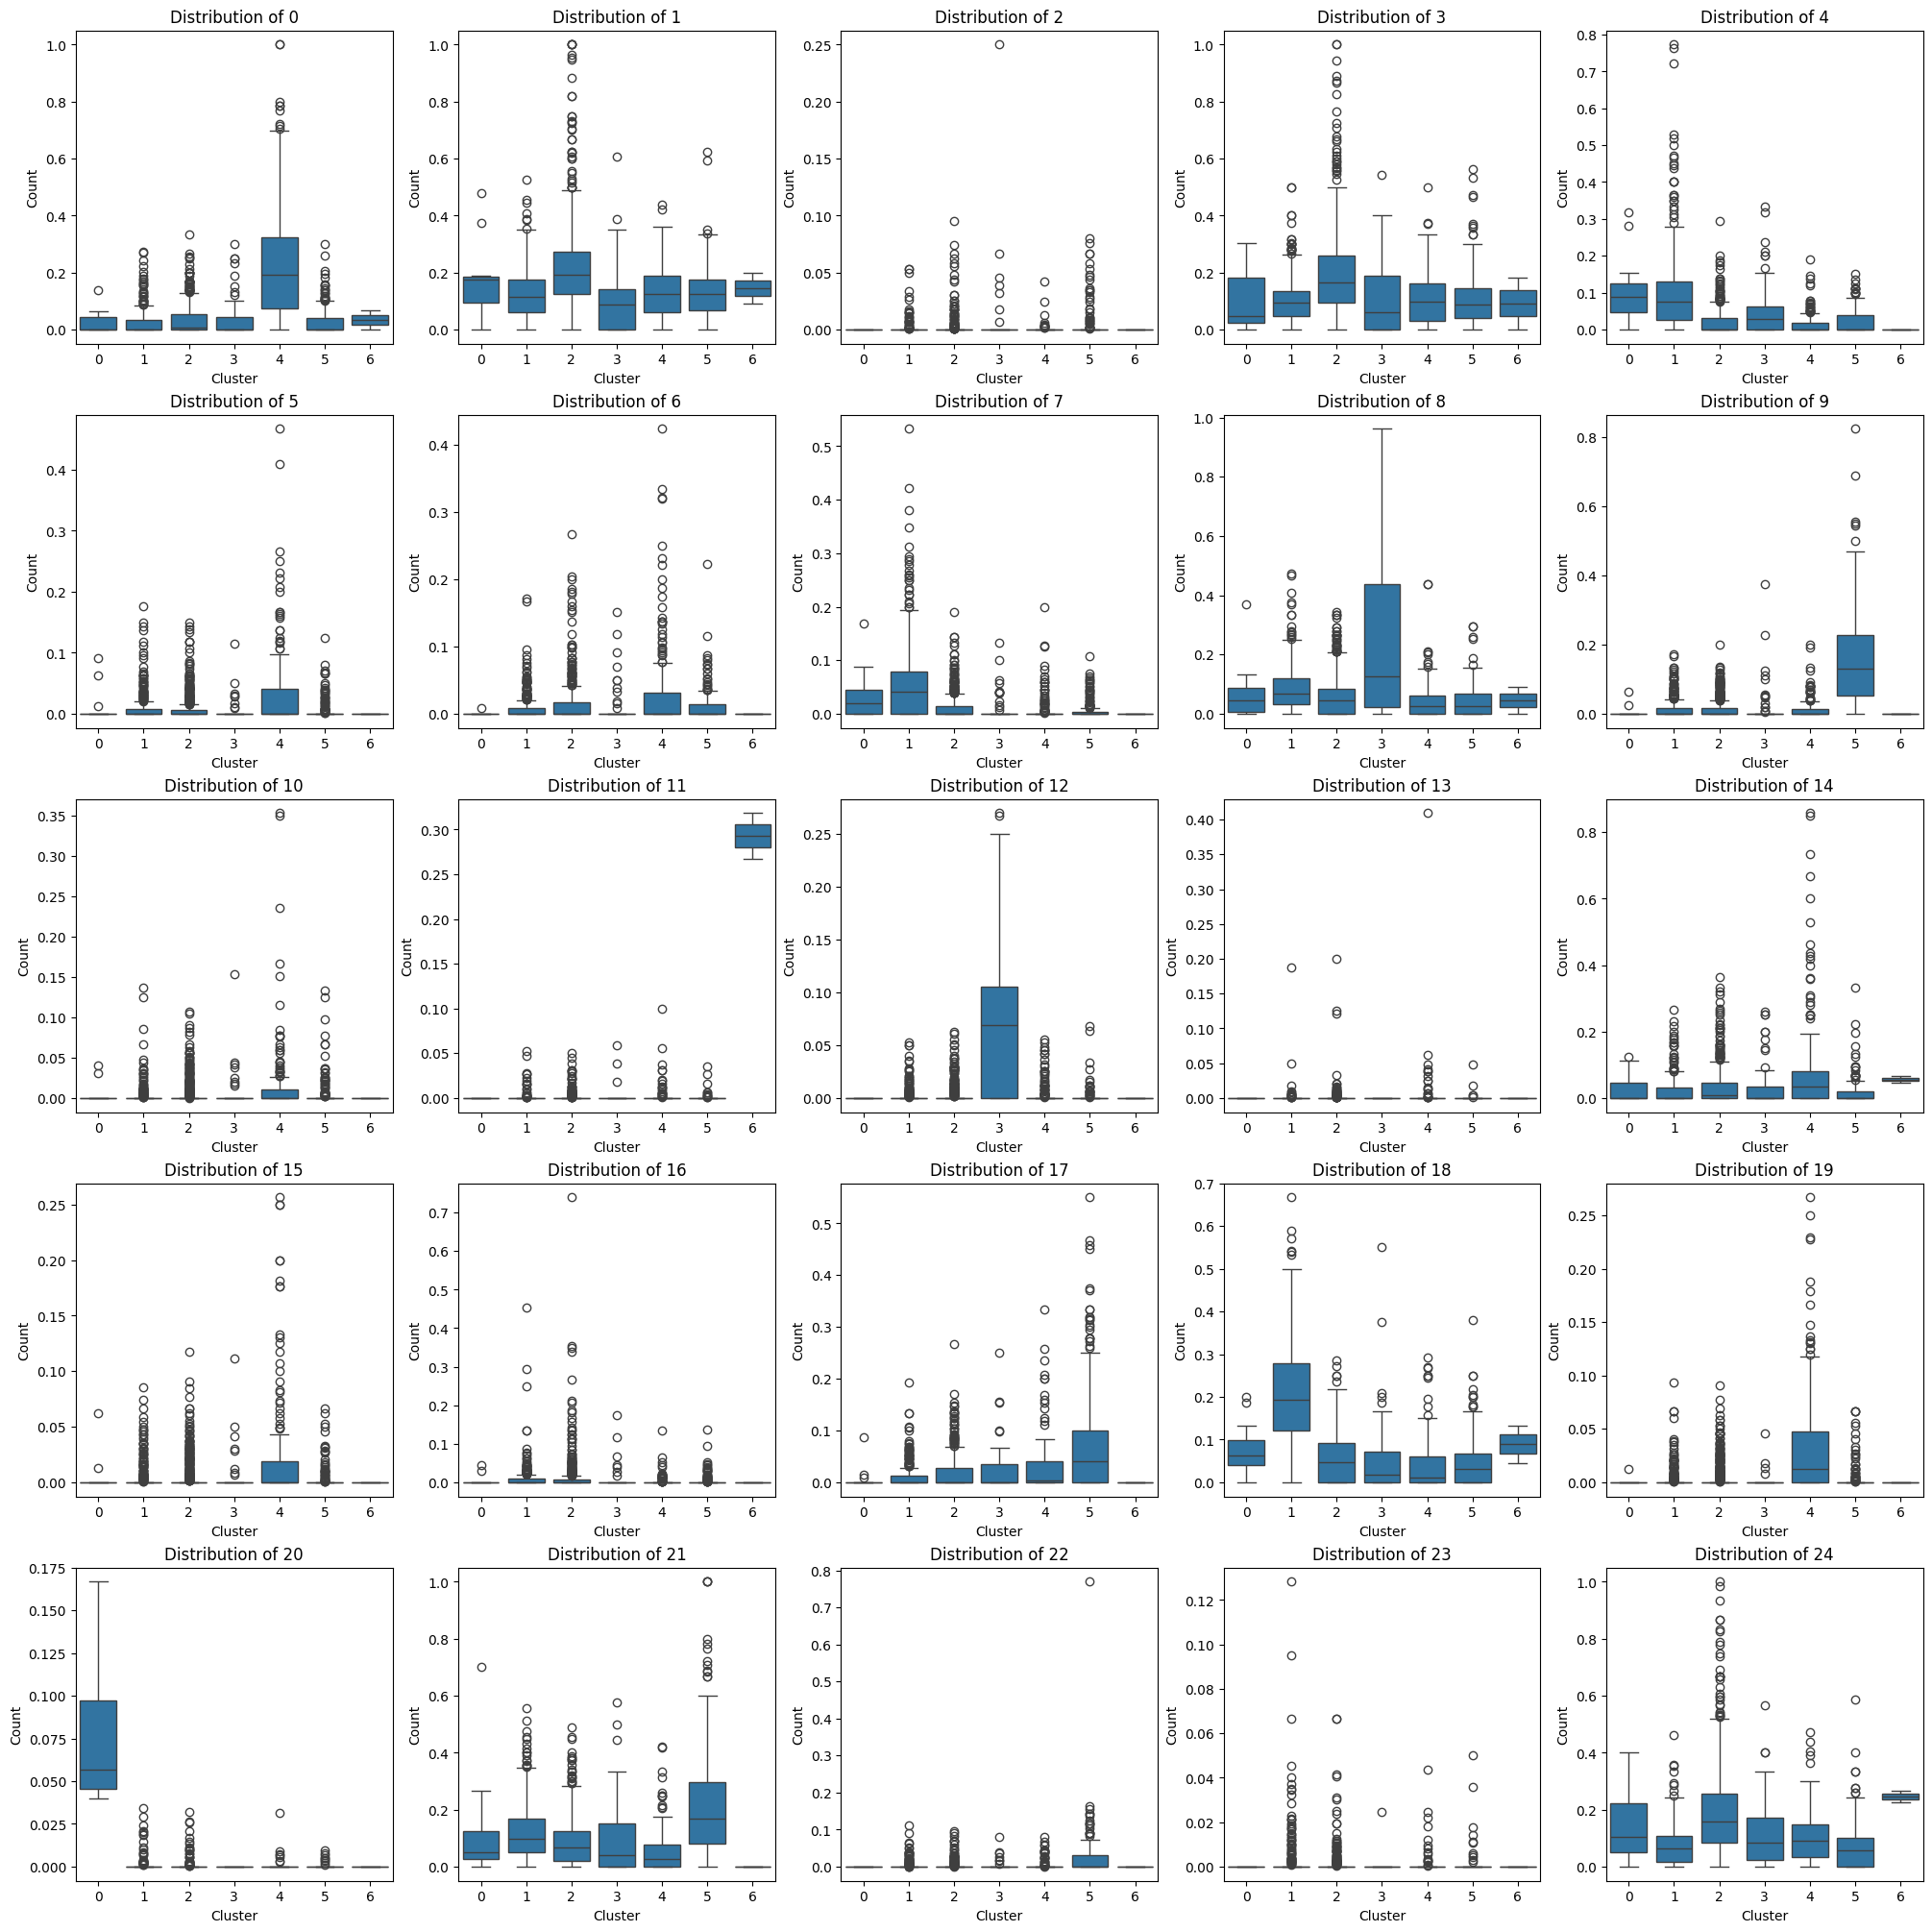

         Count     0Mean     1Mean     2Mean     3Mean     4Mean     5Mean  \
Cluster                                                                      
0           14  0.023739  0.173707  0.000000  0.102506  0.100955  0.011862   
1          366  0.025131  0.124517  0.001163  0.101021  0.101859  0.009769   
2          617  0.034124  0.220342  0.001652  0.195542  0.018618  0.008661   
3           65  0.039144  0.108243  0.007031  0.100246  0.051673  0.004559   
4          202  0.231469  0.130235  0.000535  0.107629  0.014167  0.033365   
5          197  0.029469  0.130442  0.004548  0.105167  0.023673  0.006125   
6            2  0.033333  0.145455  0.000000  0.090909  0.000000  0.000000   

            6Mean     7Mean     8Mean  ...    15Mean    16Mean    17Mean  \
Cluster                                ...                                 
0        0.000644  0.036273  0.072039  ...  0.005368  0.005445  0.007954   
1        0.008605  0.061262  0.085239  ...  0.004219  0.009898  0.010

In [386]:
clustering_features = list(range(25))

custom_cluster(users_with_all_attributes, clustering_features, 7, 'EngagementCluster', verbose=True)

#### 5.2 Clustering by topic engagement columns + MostEngadedTopic column

/Users/phog/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/phog/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


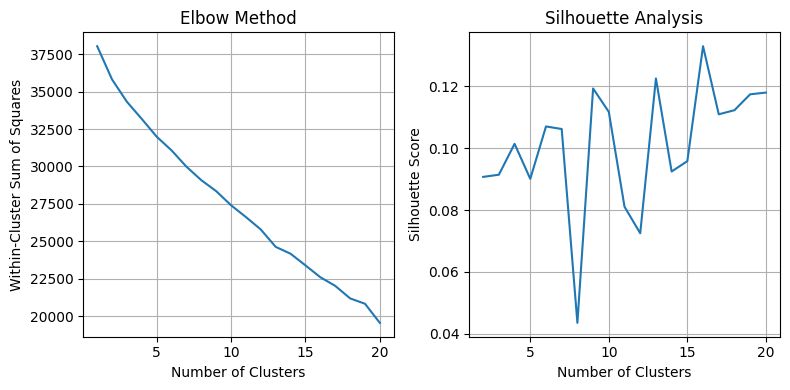

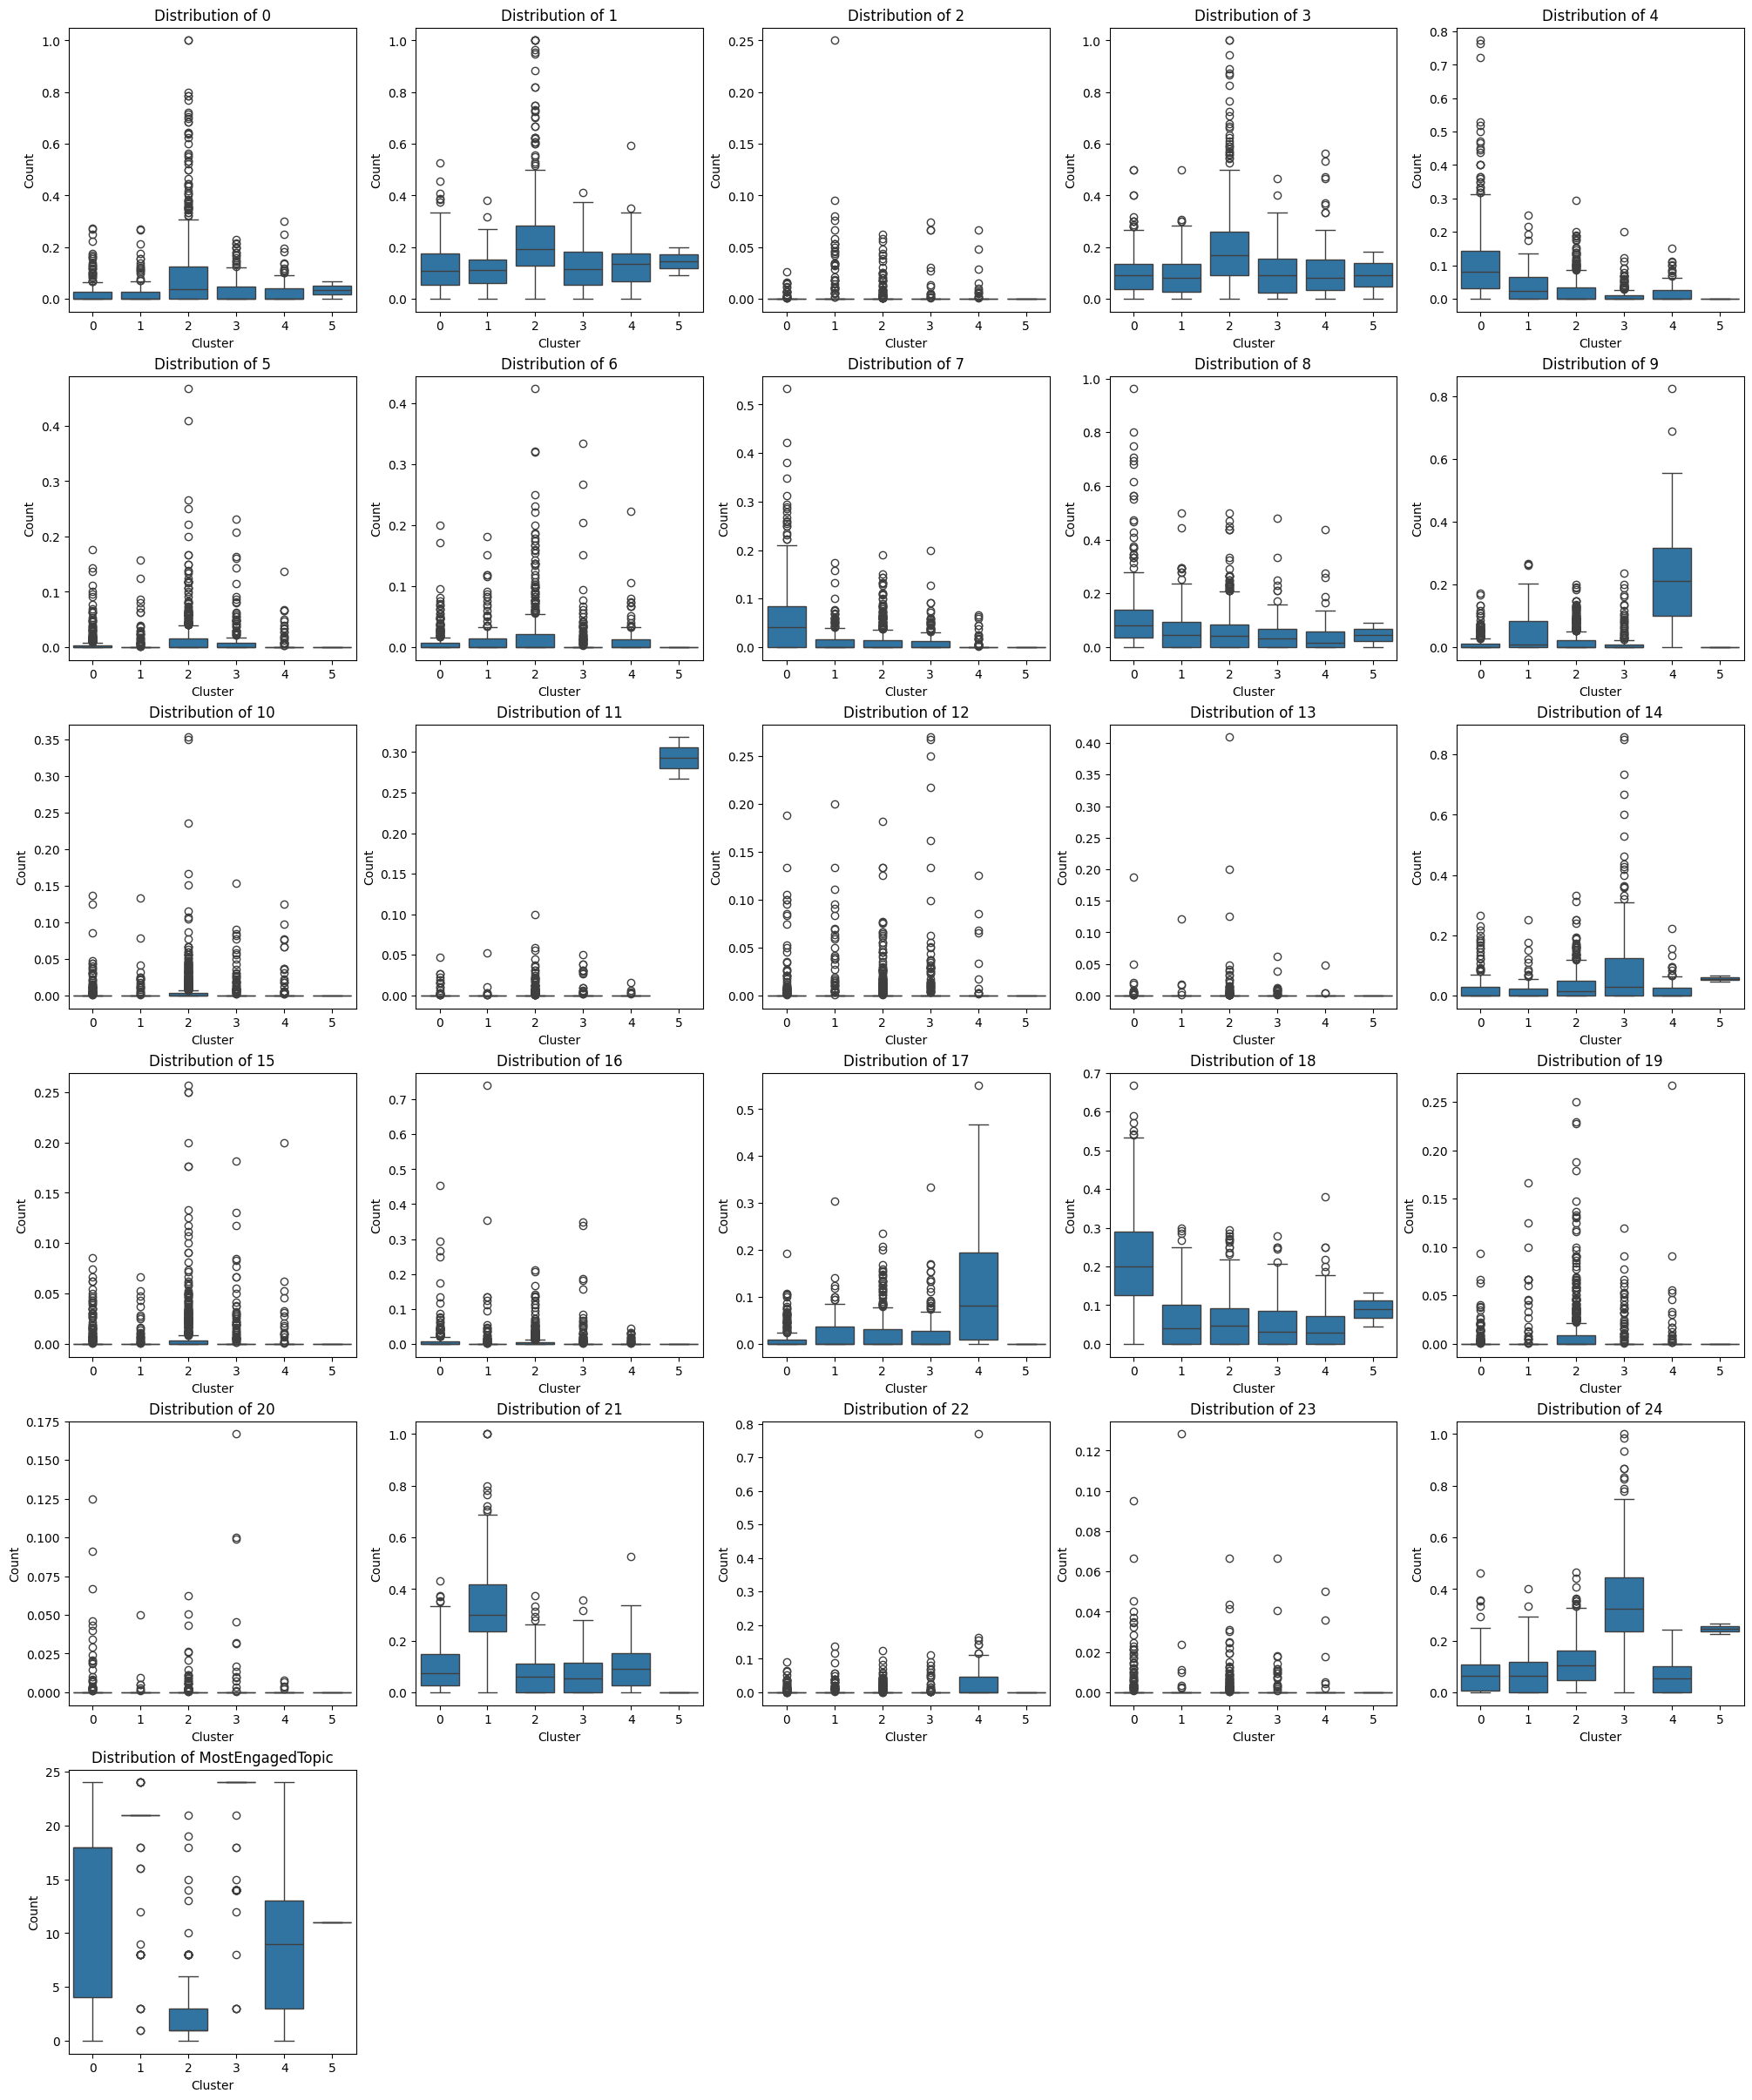

         Count     0Mean     1Mean     2Mean     3Mean     4Mean     5Mean  \
Cluster                                                                      
0          326  0.021797  0.117920  0.000511  0.096755  0.110256  0.007799   
1          157  0.024031  0.109439  0.008914  0.089957  0.037969  0.006718   
2          666  0.097051  0.222733  0.001241  0.195347  0.022235  0.015555   
3          209  0.033325  0.121365  0.001497  0.099931  0.011487  0.012665   
4          103  0.031186  0.132692  0.001951  0.110495  0.018946  0.007032   
5            2  0.033333  0.145455  0.000000  0.090909  0.000000  0.000000   

            6Mean     7Mean     8Mean  ...    16Mean    17Mean    18Mean  \
Cluster                                ...                                 
0        0.008344  0.062760  0.113320  ...  0.011736  0.010217  0.212702   
1        0.013672  0.015153  0.067041  ...  0.014359  0.022818  0.062405   
2        0.018701  0.012120  0.058938  ...  0.007662  0.019988  0.05943

In [434]:
clustering_features = list(range(25)) + ['MostEngagedTopic']

custom_cluster(users_with_all_attributes, clustering_features, 6, 'Engagement_MostEngaged_Cluster', verbose=True)

### 6. Clustering by Topic Engagement Metrics + Sentiment

#### 6.1 Clustering by topic engagement columns and Sentiment

/Users/phog/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/phog/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


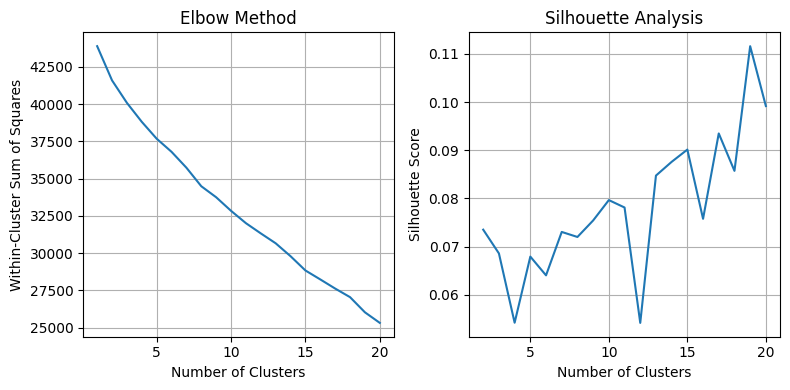

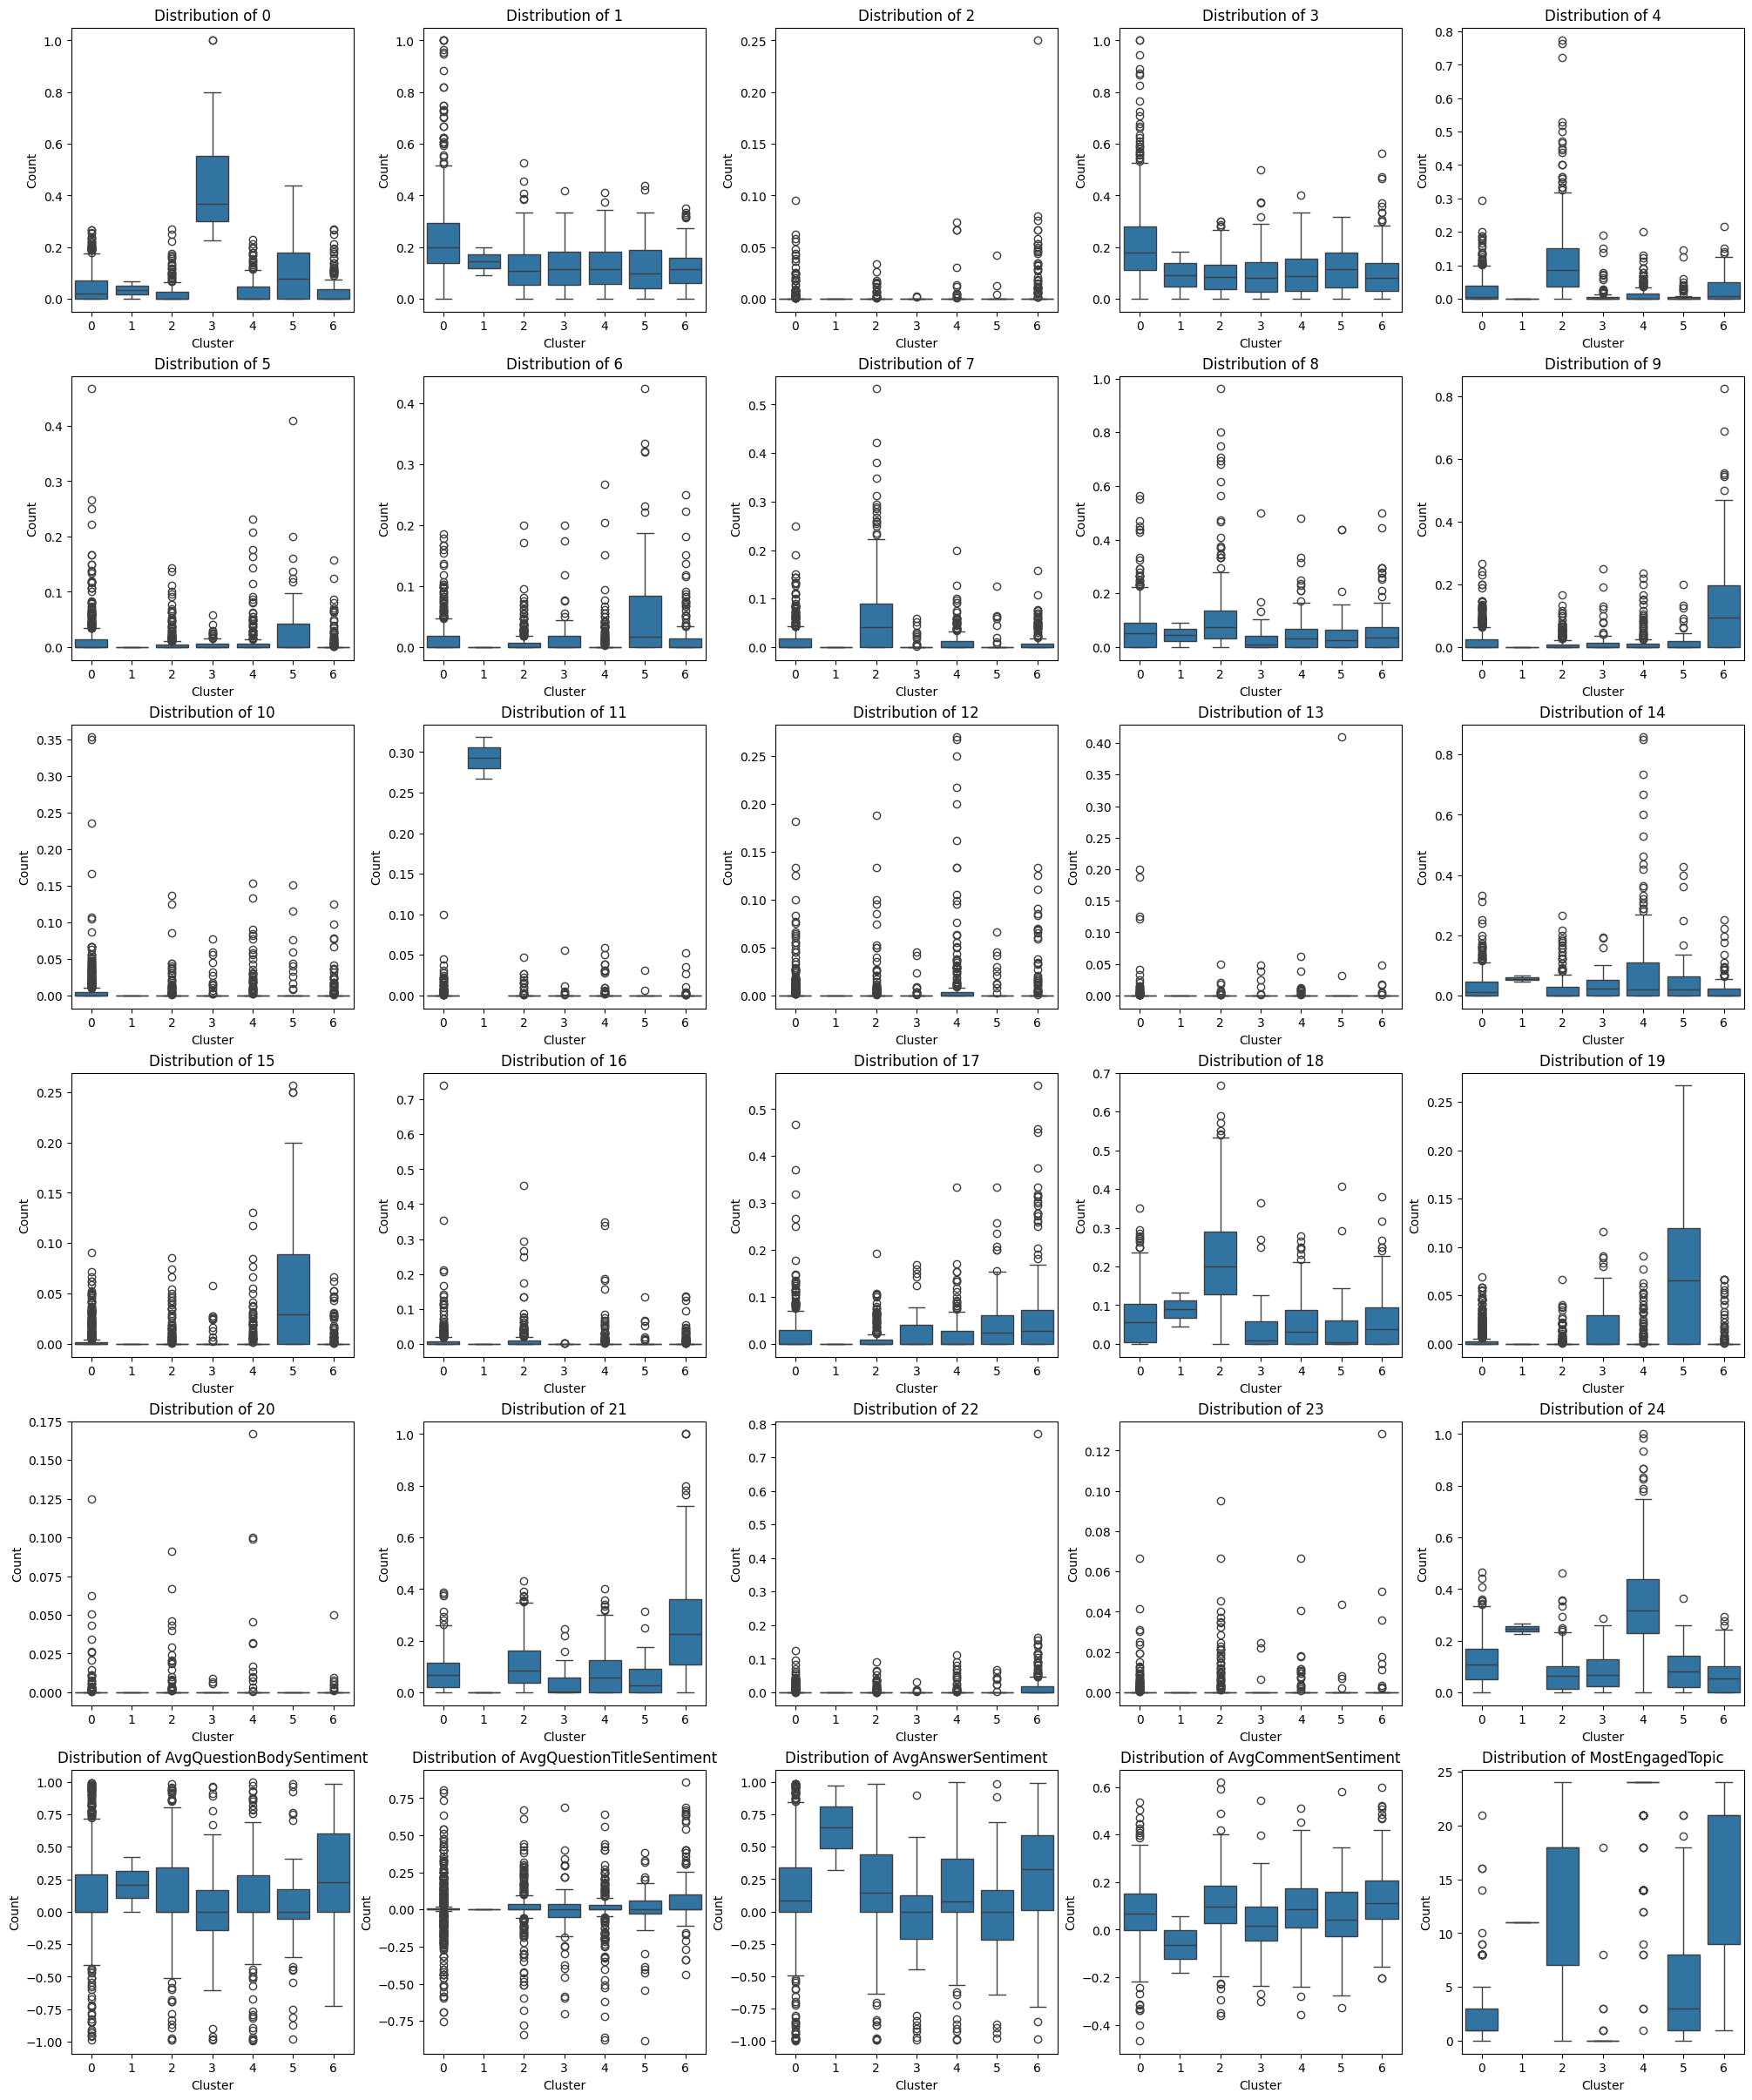

         Count     0Mean     1Mean     2Mean     3Mean     4Mean     5Mean  \
Cluster                                                                      
0          584  0.046722  0.237416  0.001554  0.211773  0.025438  0.014620   
1            2  0.033333  0.145455  0.000000  0.090909  0.000000  0.000000   
2          307  0.021032  0.116290  0.000685  0.088019  0.115310  0.007569   
3           75  0.439827  0.122845  0.000053  0.104904  0.013760  0.005473   
4          220  0.030828  0.123598  0.001299  0.099057  0.013309  0.011968   
5           58  0.104382  0.126985  0.001006  0.114955  0.011776  0.035399   
6          217  0.028228  0.114628  0.006637  0.096812  0.028415  0.006311   

            6Mean     7Mean     8Mean  ...    20Mean    21Mean    22Mean  \
Cluster                                ...                                 
0        0.013938  0.014249  0.067250  ...  0.000890  0.076037  0.003438   
1        0.000000  0.000000  0.045455  ...  0.000000  0.000000  0.000

In [416]:
clustering_features = list(range(25)) + ['AvgQuestionBodySentiment', 'AvgQuestionTitleSentiment', 'AvgAnswerSentiment', 'AvgCommentSentiment', 'MostEngagedTopic']
custom_cluster(users_with_all_attributes, clustering_features, 7, 'EngagementSentimentCluster', verbose=True)

### 7. THE GREAT CLUSTERING: Clustering by User Attributes

#### 7.1 Clustering by all attributes

In [ ]:
clustering_features = ['Reputation', 'AvgQuestionScore', 'AvgAnswerScore', 'AvgCommentScore']


In [426]:
users_with_all_attributes.columns

Index([                        'Id',                 'Reputation',
                     'CreationDate',             'LastAccessDate',
                            'Views',                    'UpVotes',
                        'DownVotes',              'QuestionCount',
                      'AnswerCount',               'CommentCount',
                    'TotalActivity',   'AvgQuestionBodySentiment',
        'AvgQuestionTitleSentiment',         'AvgAnswerSentiment',
              'AvgCommentSentiment',           'AvgQuestionScore',
                   'AvgAnswerScore',            'AvgCommentScore',
              'AcceptedAnswerCount',     'AcceptedAnswerFraction',
                                  0,                            1,
                                  2,                            3,
                                  4,                            5,
                                  6,                            7,
                                  8,                          

In [436]:
UserAttributeClusters = users_with_all_attributes[['Id', 'MostEngagedTopic', 'EngagementCluster', 'ActivityCluster', 'Quality1Cluster', 'Quality2Cluster', 'SentimentCluster', 'EngagementSentimentCluster', 'Engagement_MostEngaged_Cluster']]

In [437]:
user_attrs = UserAttributeClusters.set_index('Id').T.to_dict()
list(user_attrs.items())[:2]

[(5,
  {'MostEngagedTopic': 3.0,
   'EngagementCluster': 2.0,
   'ActivityCluster': 0.0,
   'Quality1Cluster': 0.0,
   'Quality2Cluster': 1.0,
   'SentimentCluster': 1.0,
   'EngagementSentimentCluster': 0.0,
   'Engagement_MostEngaged_Cluster': 2.0}),
 (8,
  {'MostEngagedTopic': 21.0,
   'EngagementCluster': 1.0,
   'ActivityCluster': 0.0,
   'Quality1Cluster': 1.0,
   'Quality2Cluster': 1.0,
   'SentimentCluster': 1.0,
   'EngagementSentimentCluster': 2.0,
   'Engagement_MostEngaged_Cluster': 1.0})]

In [438]:
# Iterate over the user attributes dictionary and add each to the corresponding node
for user_id, attrs in user_attrs.items():
    if user_id in G1.nodes:
        nx.set_node_attributes(G1, {user_id: attrs})

In [439]:
# Check attributes of a specific user node
print(G1.nodes[5])

{'EngagementSentimentCluster': 0.0, 'MostEngagedTopic': 3.0, 'EngagementCluster': 2.0, 'ActivityCluster': 0.0, 'Quality1Cluster': 0.0, 'Quality2Cluster': 1.0, 'SentimentCluster': 1.0, 'Engagement_MostEngaged_Cluster': 2.0}


In [440]:
# nx.write_graphml(G1, './graphml/graph2.graphml')

### Label Reshuffleing

> *"The "label shuffling technique" is incredibly useful. It may turn out to be a good tool to apply for your independent project. Keep it in mind."* - **Week8.ipynb**

Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

1. Initial Cluster Analysis
Cluster Your Data: Use a clustering algorithm (like k-means) to cluster your users based on the features you're interested in. Assign each user to a cluster.
Compute Initial Statistics: For each cluster, compute the average (or another statistic of interest) of a specific feature or set of features. These are your observed values.
2. Permutation Test Procedure
Shuffle Cluster Labels: Randomly shuffle the cluster labels assigned to the users, ensuring that the number of users in each cluster remains the same as in the original classification.
Recompute Statistics for Shuffled Data: For each shuffled configuration, recompute the same statistics as in your initial analysis for each cluster.
Repeat the Process: Perform this shuffling and recomputing process a large number of times (typically 1000 or more) to build a distribution of the statistic under the null hypothesis.
3. Analysis and Comparison
Create Histograms: For each cluster, create histograms of the computed statistics from the shuffled data.
Compare Observed Values with Distributions: Compare the initially observed values for each cluster with the distributions obtained from the shuffled data. If your observed value lies outside the bulk of the distribution for shuffled data, it suggests that the observed value is not simply due to random chance.
4. Statistical Significance
P-Value Calculation: For each cluster, you can calculate a p-value, which is the proportion of the shuffled datasets where the computed statistic was as extreme as the observed statistic. A small p-value indicates that the observed statistic is unusual under the null hypothesis of random distribution of features.
5. Interpretation
Draw Conclusions: Based on where your observed statistics fall in relation to the distributions from the shuffled data, draw conclusions about whether the features in each cluster are significantly different from what would be expected by chance.

In [423]:
def compute_stats(df, features, cluster_column):
    """
    Compute the average and standard deviation for specified features within each cluster.

    :param df: Pandas DataFrame containing the user data.
    :param features: List of features (column names) for which to compute statistics.
    :param cluster_column: Name of the column containing cluster labels.
    :return: A dictionary containing the stats for each cluster.
    """
    cluster_stats = {}
    for cluster in df[cluster_column].unique():
        cluster_data = df[df[cluster_column] == cluster]
        stats_dict = {feature: {
                        'mean': cluster_data[feature].mean(), 
                        'std': cluster_data[feature].std()
                      } for feature in features}
        cluster_stats[cluster] = stats_dict
    return cluster_stats

In [ ]:
user_attrs = users_with_all_attributes.set_index('Id').T.to_dict()
user_attrs

{5: {'Reputation': 315,
  'CreationDate': Timestamp('2012-12-04 20:36:06.517000'),
  'LastAccessDate': Timestamp('2021-07-05 18:03:41.037000'),
  'Views': 49,
  'UpVotes': 14,
  'DownVotes': 58,
  'QuestionCount': 0.0,
  'AnswerCount': 3.0,
  'CommentCount': 31.0,
  'TotalActivity': 34.0,
  'AvgQuestionBodySentiment': 0.0,
  'AvgQuestionTitleSentiment': 0.0,
  'AvgAnswerSentiment': 0.18543333333333334,
  'AvgCommentSentiment': 0.46940645161290323,
  'AvgQuestionScore': nan,
  'AvgAnswerScore': 7.0,
  'AvgCommentScore': 1.1935483870967742,
  'AcceptedAnswerCount': 1.0,
  'AcceptedAnswerFraction': 0.3333333333333333,
  0: 0.0,
  1: 0.20588235294117646,
  2: 0.0,
  3: 0.23529411764705882,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.20588235294117646,
  9: 0.029411764705882353,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.029411764705882353,
  15: 0.0,
  16: 0.0,
  17: 0.029411764705882353,
  18: 0.029411764705882353,
  19: 0.0,
  20: 0.0,
  21: 0.058823529411764705,
  22: 0.0,
 

In [ ]:
# Save Results

#nx.write_graphml(G1, './graphml/graph1.graphml')
#nx.write_graphml(G2, 'graph2.graphml')